In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# Import the mobilenet_v2 model from torchvision's models module with pretrained weights
pretrained_mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
# Retrieve and list the last three layers/children of the pretrained mobilenet model
list(pretrained_mobilenet.children())[-3:] 

c:\Users\Lenovo\anaconda3\envs\py37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\Lenovo\anaconda3\envs\py37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU6(inplace=True)
   )
   (1): InvertedResidual(
     (conv): Sequential(
       (0): Conv2dNormActivation(
         (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
         (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU6(inplace=True)
       )
       (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (2): InvertedResidual(
     (conv): Sequential(
       (0): Conv2dNormActivation(
         (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running

In [3]:
# Create a new Sequential model 'net' by unpacking all layers (children) from the pretrained mobilenet,
# except for the last one, effectively removing it.
net = nn.Sequential(*list(pretrained_mobilenet.children())[:-1]) 
# Create a random tensor 'X' which simulates a single image with 3 channels (RGB) and dimensions 320x480.
# The dimensions are in the format (batch_size, channels, height, width).
X = torch.rand(size=(1, 3, 320, 480)) 
# Pass the random 'X' tensor through the modified network 'net' to get the output shape.
# This is typically used to understand the output dimensions the network produces for a given input size.
net(X).shape  

torch.Size([1, 1280, 10, 15])

In [4]:
# Set the number of output classes for the network to 21.
num_classes = 21
# Add a 1x1 convolutional layer to the network 'net' to map each 1280-dimensional feature to 21 classes.
net.add_module('final_conv', nn.Conv2d(1280, num_classes, kernel_size=1))
# Add a transpose convolutional layer to 'net', which upsamples the feature map back to the input image size.
# It has 21 input channels, 21 output channels, a kernel size of 64, padding of 16, and a stride of 32.
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))

In [5]:

def bilinear_kernel(in_channels, out_channels, kernel_size):
    # Calculate the factor for centering the kernel and determining its range.
    factor = (kernel_size + 1) // 2
    # Find the center of the kernel. It's slightly different for even and odd kernel sizes.
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5

    # Create a grid of (x, y) coordinates representing the kernel indices.
    og = (torch.arange(kernel_size).reshape(-1,1),
        torch.arange(kernel_size).reshape(1,-1))
    
    # Calculate the bilinear kernel using the absolute distance from the center, normalized by the factor.
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)    
    # Initialize the weight matrix for all channels with zeros.
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))  
    # Assign the calculated bilinear kernel filter to the corresponding place in the weight matrix.
    weight[range(in_channels),range(out_channels),:,:] = filt
    return weight


input image shape: torch.Size([717, 1280, 3])
output image shape: torch.Size([1434, 2560, 3])


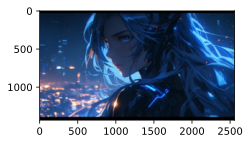

In [6]:
# Define a transposed convolution layer with 3 input channels, 3 output channels, kernel size of 4,
# padding of 1, stride of 2, and no bias. This will upsample the input image.
conv_trans = nn.ConvTranspose2d(3,3,kernel_size=4,padding=1,stride=2,bias=False)  

# Initialize the weights of the transposed convolution layer using a bilinear kernel.
conv_trans.weight.data.copy_(bilinear_kernel(3,3,4)) 

# Load an image with path '1.jpg', convert it to a tensor, and add a batch dimension at the beginning.
img = torchvision.transforms.ToTensor()(d2l.Image.open('1.jpg'))
X = img.unsqueeze(0)

# Pass the image tensor through the transposed convolution layer to upsample it.
Y = conv_trans(X)

# Rearrange the dimensions of the output for visualization and detach it from the computation graph.
out_img = Y[0].permute(1,2,0).detach()

# Set the figure size for matplotlib plots.
d2l.set_figsize()

# Print the shape of the input image and display it.
print('input image shape:', img.permute(1,2,0).shape)
d2l.plt.imshow(img.permute(1,2,0))

# Print the shape of the output image (upsampled) and display it.
print('output image shape:',out_img.shape) 
d2l.plt.imshow(out_img)

In [7]:
# Create a bilinear kernel for the transpose_conv layer with a size of 64.
W = bilinear_kernel(num_classes, num_classes, 64)
# Initialize the transpose_conv layer's weights with the bilinear kernel.
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [8]:
# Set the batch size for training and the dimensions for cropping the images.
batch_size, crop_size = 32, (320,480)
# Load the training and testing datasets for semantic segmentation using the VOC dataset, with specified
# batch size and crop size.
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.408, train acc 0.870, test acc 0.856
2.3 examples/sec on [device(type='cpu')]


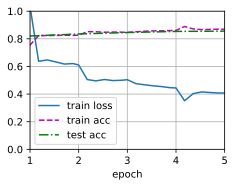

In [9]:
# Define a loss function that calculates the cross-entropy loss for each pixel and averages over all pixels.
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)    

# Set the number of epochs, learning rate, weight decay, and devices (GPUs) for training.
num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()

# Initialize the optimizer (SGD) with the network parameters, learning rate, and weight decay.
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# Train the model using the defined network, loss function, optimizer, and datasets for the specified epochs and devices.
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)   

In [10]:
def predict(img):
    # Normalize the image and add a batch dimension before passing it to the network
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # Forward the image through the network, move it to the appropriate device, and obtain the predicted class for each pixel.
    pred = net(X.to(devices[0])).argmax(dim=1) 
    # Reshape the prediction to match the image's height and width.
    return pred.reshape(pred.shape[1],pred.shape[2]) 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

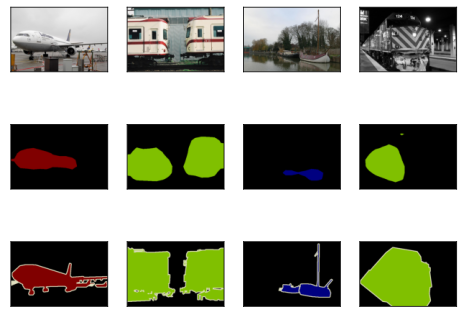

In [11]:
# Convert a prediction tensor to an image by mapping each pixel's class label to its corresponding color.
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long() # Ensure the predictions are long integers for indexing.
    return colormap[X,:] # Map each label to its color.
# Download and extract the VOC2012 dataset.
voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')

# Read the test images and labels from the dataset.
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, [] # Set number of images to display and initialize an image list.
for i in range(n):
    crop_rect = (0,0,320,480) # Define the crop size.
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect) # Crop the test image.
    pred = label2image(predict(X)) # Predict and convert the prediction to an image.
    # Store the cropped test image, prediction, and cropped label for display.
    imgs += [X.permute(1,2,0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1,2,0)]

# Display the test images, their corresponding predictions, and ground truth labels in a grid.    
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3],3,n,scale=2) 